In [121]:

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import easyocr
from src import constants
import re
import csv
import os

In [122]:
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


c:\Users\jatin\anaconda3\Lib\site-packages\easyocr\detection.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model,

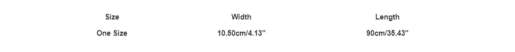

In [185]:
path = r"D:\Dataset\New\images\11gHj8dhhrL.jpg"

image = cv2.imread(path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [186]:
results = reader.readtext(image)

In [187]:
print(results)

[([[191, 7], [223, 7], [223, 25], [191, 25]], 'Size', 0.5546192190027898), ([[445, 9], [489, 9], [489, 25], [445, 25]], 'Width', 0.999702886930172), ([[735, 9], [789, 9], [789, 27], [735, 27]], 'Length', 0.9999795598178105), ([[175, 39], [239, 39], [239, 57], [175, 57]], 'One Size', 0.801585312022577), ([[417, 39], [519, 39], [519, 57], [417, 57]], '10.50cm/4.13"', 0.9445815179139814), ([[717, 39], [807, 39], [807, 57], [717, 57]], '90cm/35.43"', 0.8982641120222012)]


In [188]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(gray,(500,500))
    return resized_img

In [189]:
def extract_text(image_path):
    preprocessed_img = preprocess_image(image_path)
    result = reader.readtext(preprocessed_img)

    extracted_text = " ".join([text[1] for text in result])
    return extracted_text

In [190]:
txt =extract_text(path)
txt

'M H M'

In [180]:

unit_abbreviation_mapping = {
    "cm": "centimetre",
    "centimeter": "centimetre",
    "mm": "millimetre",
    "millimeter": "millimetre",
    "kg": "kilogram",
    "kilogramme": "kilogram",
    "g": "gram",
    "gm": "gram",
    "gramme": "gram",
    "ml": "millilitre",
    "milliliter": "millilitre",
    "l": "litre",
    "lt": "litre",
    "m": "metre",
    "meter": "metre",
    "kv": "kilovolt",
    "v":"volt",
    "kw": "kilowatt",
    "w":"watt",
    "oz": "ounce",
    "ft": "foot",
    "foot": "foot",
    "in": "inch",
    "inch": "inch",
    "lbs":"pound",

}

In [181]:
ocr_correction ={"S":"5", "O":"0"}
def correct_ocr_errors(text):
    for incorrect,correct in ocr_correction.items():
        text = text.replace(incorrect,correct)
    return text

In [182]:
def map_abbreviation_to_unit(unit):
    unit = unit.lower().strip()
    return unit_abbreviation_mapping.get(unit,unit)



In [183]:
def map_extracted_text_to_values(extracted_text):
    extracted_text = correct_ocr_errors(extracted_text)
    extracted_text = re.sub(r'\s+', ' ', extracted_text).strip()
    pattern= r"(\d+(?:\.\d+)?)\s*(\w+)"
    matches = re.findall(pattern,extracted_text)

    mapped_values = []
    for value,unit in matches:
        full_unit = map_abbreviation_to_unit(unit)
        if full_unit in constants.allowed_units:
            return f"{float(value)} {full_unit}"
  

In [184]:
mapped_val = map_extracted_text_to_values(txt)
print(mapped_val)

7.6 centimetre


In [166]:
def process_single(image_folder_path, output_csv):

    output_folder = 'output'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    output_path = os.path.join(output_folder, output_csv)

    with open(output_path, mode = 'w', newline = '') as file:
        writer = csv.writer(file)
        writer.writerow(['index','prediction'])

        for index,filename in enumerate(os.listdir(image_folder_path)):
            print(f"processing image: {index+1} and file : {filename} ")
            if index+1 == 40:
                break

            if filename.lower().endswith(('.png','.jpg','.jpeg')):
                image_path = os.path.join(image_folder_path,filename)
                extracted_text = extract_text(image_path)
                prediction = map_extracted_text_to_values(extracted_text)

  
            writer.writerow([index,prediction])
    print(f"output csv saved as {output_csv}")



        

In [167]:
image_folder = 'images'
process_single(image_folder,'test_out.csv')

processing image: 1 and file : 110EibNyclL.jpg 
processing image: 2 and file : 11gHj8dhhrL.jpg 
processing image: 3 and file : 11lshEUmCrL.jpg 
processing image: 4 and file : 11TU2clswzL.jpg 
processing image: 5 and file : 21+i52HRW4L.jpg 
processing image: 6 and file : 21-LmSmehZL.jpg 
processing image: 7 and file : 213oP6n7jtL.jpg 
processing image: 8 and file : 213wY3gUsmL.jpg 
processing image: 9 and file : 214CLs1oznL.jpg 
processing image: 10 and file : 216rjgJHAeL.jpg 
processing image: 11 and file : 2174yonQBtL.jpg 
processing image: 12 and file : 218BCzgKxuL.jpg 
processing image: 13 and file : 21aD6ktvwxS.jpg 
processing image: 14 and file : 21bfrFeArAL.jpg 
processing image: 15 and file : 21BMc5GC4iL.jpg 
processing image: 16 and file : 21bwWoCpGJL.jpg 
processing image: 17 and file : 21cLufe8Y5L.jpg 
processing image: 18 and file : 21CxlWbim3L.jpg 
processing image: 19 and file : 21d6Dtc94mL.jpg 
processing image: 20 and file : 21DZ7BAZ6-L.jpg 
processing image: 21 and file

In [75]:
import pandas as pd


In [76]:
df = pd.read_csv('test.csv')

In [77]:
df.head()

,index,prediction
0,0,4 0 . 0 w a t t


In [78]:
df['prediction'][0]

'4 0 . 0   w a t t'